In [2]:
import utils, sklearn_ext
utils=reload(utils)
sklearn_ext=reload(sklearn_ext)
import pandas as pd
import numpy as np
np.random.seed(0)
import sklearn
import itertools, functools, re, pickle, gzip, pprint,os
from collections import defaultdict
from functools import partial
from io import StringIO
import joblib

In [6]:
# MODEL='RF'
MODEL='XGBT'
DYNAMIC_PREDICT=True
IMPUTE=False

WEATHER=True
MULTIOUTPUT=False
OHE=False
DROP_CLOSE=False 
LOG_TRANS=False    # log transform to Y , 反而變差 , 難道要power transform?
VALUE_IMPUTE_MISSING=-999
COL_Y='Sales'
COL_Y2='Customers'
if MULTIOUTPUT: Y_COLS=[COL_Y,COL_Y2]

# Load

In [7]:
bucket='gs://rossmann'
%storage read -o {bucket}/data/train.csv -v train_data
%storage read -o {bucket}/data/test.csv -v test_data
%storage read -o {bucket}/data/store.csv -v store_data
%storage read -o {bucket}/data/state.csv -v state_data
%storage read -o {bucket}/data/holiday.csv -v holiday_data
%storage read -o {bucket}/data/weather.csv -v weather_data
%storage read -o {bucket}/data/weather.csv -v weather_data

train_df=utils.load_train(train_data)
if IMPUTE:
  %storage read -o {bucket}/data/Yimpute.csv -v Yimpute
  Yimpute=pd.read_csv(StringIO(unicode(Yimpute)))
  Yimpute['Date']=Yimpute.Date.astype(np.datetime64)
  Yimpute=Yimpute.set_index(['Store','Date'])
  train_df=train_df.set_index(['Store','Date'])
  train_df.loc[Yimpute.index,Yimpute.columns]=Yimpute
  train_df=train_df.reset_index()

test_df=utils.load_test(test_data)
store_df=utils.load_store(store_data,state_data)
holiday_df=utils.load_holiday(holiday_data)
weather_df=pd.read_csv(StringIO(unicode(weather_data)))
weather_df['Date']=pd.to_datetime(weather_df.Date)

In [9]:
train_df[train_df.isnull().any(1)].shape

(33121, 8)

# Preprocess


In [13]:
def preprocess(train,test,store,holiday,weather,
               ohe=OHE,dynamic_predict=DYNAMIC_PREDICT,drop_na_y=True,
               multioutput=MULTIOUTPUT,drop_close=DROP_CLOSE):
    Y_cols = [COL_Y,COL_Y2]  if multioutput else [COL_Y]
    to_be_dropped=['Id','Date']
    if not multioutput: to_be_dropped+=[COL_Y2] # 

    df=pd.concat([train,test],axis=0)
    df=df.sort_values(by=['Store','Date']).reset_index(drop=True)
    assert len(df)==train.Store.nunique()*((train.Date.max()-train.Date.min()).days+1)+\
                    test.Store.nunique()*((test.Date.max()-test.Date.min()).days+1)
    # =======================================
#     if LOG_TRANS:
  #     df[COL_Y]=np.log1p(df[COL_Y])
  #     df[COL_Y2]=np.log1p(df[COL_Y2])
    # extract date features and store feaures
    df,_to_be_dropped=utils.basic_features(df,store)
    to_be_dropped+=_to_be_dropped
    
    # 
    # padding , so that duration or time-series features do not end with nan
    df=utils.padding(df) 
    df = df.sort_values(by=['Store', 'Date']).reset_index(drop=True)
    
    #=====join holiday and weather data ======
    _len_df=len(df)
    df=utils.holiday_features(df,holiday)
    to_be_dropped+=['StateHoliday','HolidayStates']
    if WEATHER:
      assert df.Date.dtype==weather.Date.dtype
      df=df.merge(weather,on=['Date','State'],how='left')
      assert _len_df==len(df)
    
    cols=['Sales','Customers','StateSales_mean','StateSales_std','GroupSales_mean','GroupSales_std']
    MA_order=[63,]
    for order in MA_order:
        df,_to_be_dropped=utils.window_statistics(df,order,cols)
        to_be_dropped+=_to_be_dropped
        df['S/C_EMA'+str(order)] = df['Sales_EMA'+str(order)] / df['Customers_EMA'+str(order)]
        df['S/C_EMSTD'+str(order)] = df['Sales_EMSTD'+str(order)] / df['Customers_EMSTD'+str(order)]
        to_be_dropped+=['S/C_EMA'+str(order), 'S/C_EMSTD'+str(order),]
    weekday_MA_order=[21,]
    for order in weekday_MA_order:
        df,_to_be_dropped=utils.window_statistics_by_weekday(df,order,cols)
        to_be_dropped+=_to_be_dropped
        df['S/CByWeekDay_EMA'+str(order)] = df['SalesByWeekDay_EMA'+str(order)] / df['CustomersByWeekDay_EMA'+str(order)]
        df['S/CByWeekDay_EMSTD'+str(order)] = df['SalesByWeekDay_EMSTD'+str(order)] / df['CustomersByWeekDay_EMSTD'+str(order)]
        to_be_dropped+=['S/CByWeekDay_EMA'+str(order),'S/CByWeekDay_EMSTD'+str(order)]

    df,_to_be_dropped=utils.weekday_diff(df,cols)
    to_be_dropped+=_to_be_dropped
    
    df,_to_be_dropped=utils.window_statistics(df,14,['Open'])
    to_be_dropped+=_to_be_dropped
    
    
    # ========== dynamic features =========
    #"""set dynamic features"""# * need complete date time index, so don't drop anything
    df=utils.dynamic_features(df,state_columns=['Promo','Open','SchoolHoliday','IsPromo2Month'],)#  state_offsets=[],#binary state 不需要
    if WEATHER:
        df=utils.dynamic_features(df,state_columns=['Fog','Hail','Rain','Snow','Thunderstorm'])
        df=utils.dynamic_features(df,conti_columns=['Fog','Hail','Rain','Snow','Thunderstorm',
                                                    'MeanDew_PointC','CloudCover','Precipitationmm','Mean_VisibilityKm'],
                                  time_offsets=[-3,-2,-1,+1,+2,+3])
    df=utils.dynamic_features(df,event_columns=['HolidayType','HolidayName','IsHoliday'],
                              event_offsets=[-1,1],)#offset效果不好
    df=utils.dynamic_features(df,conti_columns=['Promo','Open_EMA14'],time_offsets=[-7,+7],)

    cols=['Customers','Sales','S/C','StateSales_mean','StateSales_std','GroupSales_mean','GroupSales_std',]
    for order in MA_order:
        df=utils.dynamic_features(df,conti_columns=[name+'_EMA'+str(order) for name in cols]+[name+'_EMSTD'+str(order) for name in cols],
                            time_offsets=[-52*i for i in (1,2,3)])# min is -49, test data has 48 days
    for order in weekday_MA_order:
        df=utils.dynamic_features(df,conti_columns=
                                  [name+'ByWeekDay'+'_EMA'+str(order) for name in cols]+
                                  [name+'ByWeekDay'+'_EMSTD'+str(order) for name in cols],
                          time_offsets=[-49,-50,-51,-52,-53,-54,-55]+[-49* i for i in (2,3)])

    df=utils.dynamic_features(df,conti_columns=
                            [name+'ByWeekDay'+'_Diff' for name in cols if name != 'S/C'] ,
                      time_offsets=[-49,-50,-51,-52,-53,-54,-55]+[-49* i for i in (2,3)])
  
    if dynamic_predict:
#         df=utils.dynamic_features(df,conti_columns=['Customers_MA14','Sales_MA14',],#'S/C_14',
#                                      time_offsets=[])          
        df=utils.dynamic_features(df,conti_columns=Y_cols,
                                 time_offsets=[-1,-2,
                                               -7,-14,])          
    
    # ! depadding !
    df=utils.depadding(df)
    assert len(df)==len(train)+len(test)
    # ===================encoding====================
    # set one hot features 
    if ohe:
        ohe_cats=['StoreType','Assortment','PromoInterval','WeekDay','StateHoliday',
                  'State','HolidayType','HolidayName','Events']
        for col in df.columns:
            for ohe_col in ohe_cats:
              if re.match(r'{}.+'.format(ohe_col),col): ohe_cats+=[col]
        df=pd.get_dummies(df,columns=ohe_cats,dummy_na=True)

    # random encoding the rest obj type
    obj_cols=set(filter(lambda x : df[x].dtype.kind == "O",df.columns)).difference(['Date'])
    df = sklearn_ext.ObjIndexer(obj_cols).fit(df).transform(df) # random encoding / StringIndexer

    if drop_close:
        df=df[df.Open==1]
        df=df[(df.Sales>=10)|(df.Sales.isnull())]
    # ====================    
    df=df.sort_values(by=['Store','Date']).reset_index(drop=True)
    train_df,test_df=df[df.Date<=train.Date.max()],df[df.Date>train.Date.max()]

    # drop NaN  ** dorp rows if nan y **
    if drop_na_y:
        train_df=train_df[~train_df[Y_cols].isnull().any(1)]
    # nan encoding for numerical X columns -- for training tree models.
    X_col=train_df.columns.difference(Y_cols)
    train_df[X_col]=train_df[X_col].fillna(VALUE_IMPUTE_MISSING)        
    
    # ======= keep meta-data =====
    train_df=train_df.set_index(['Store','Date'],drop=False)
    test_df=test_df.set_index(['Store','Date'],drop=False)
    id=test_df['Id']  #will be used for submission
    # ========drop useless and non-feature columns=========
    train_df=train_df.drop(to_be_dropped,axis=1)
    test_df=test_df.drop(to_be_dropped,axis=1)
    # take out Y and X
    Xtrain, Ytrain = train_df[train_df.columns.difference(Y_cols)], train_df[Y_cols]
    Xtest = test_df[test_df.columns.difference(Y_cols)]
    return Xtrain,Ytrain,Xtest,id#,index_train,index_test

In [15]:
%%time
FROM_LAST=False
postfix='_dynamic'
# postfix=''
# postfix='_complete'
if FROM_LAST: 
    X,Y,Xtest,id=joblib.load( "data/preprocessed_data{}.pkl".format(postfix))
else:
    X,Y,Xtest,id = preprocess(train_df,test_df,store_df,holiday_df,weather_df)
    joblib.dump((X,Y,Xtest,id), "data/preprocessed_data{}.pkl".format(postfix));

IOError: [Errno 2] No such file or directory: 'data/preprocessed_data_dynamic.pkl'

In [8]:
X.shape

(1017209, 421)

# Model

In [30]:
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from sklearn.grid_search import GridSearchCV
# sample_weight=~(date_X.between('2013-11-13','2014-01-15') | date_X.between('2014-11-13','2015-01-15'))+1
class DynamicXGBRegressor(xgb.XGBRegressor):
    def predict(self, X):
        Yhat = dynamic_predict(super(DynamicXGBRegressor, self),
                               X, time='Date', subject='Store', Y_column_names=['Sales'], force=True)
        return Yhat

if MODEL =='RF':
    param_grid={'n_estimators':[48],#'max_depth':[1],
    #        'max_features':[1.0,0.8],
    #         "min_samples_split":[2,5,10],
               }
    fix_params={"criterion":'mse', 'random_state':0,'n_jobs': -1,}#         'oob_score':False, 'bootstrap':True, 'warm_start':True
    fit_params=lambda X,Y,Xv,Yv:{}
    if DYNAMIC_PREDICT:
        Model=partial(sklearn_ext.DynamicExtraTreesRegressor,Y_column_names=Y_COLS,**fix_params)
    else:
        Model=partial(ExtraTreesRegressor,**fix_params)
    
elif MODEL=='XGBT':
    param_grid={ 'n_estimators': [3000], #3000,
                'max_depth': [10], #12
                "learning_rate": [0.02], #0.03
                "subsample": [0.9], #0.9
                "colsample_bytree": [0.7], #0.7 
               }
    fix_params={ "objective": "reg:linear","seed": 19,'nthread':-1}
    fit_params=lambda X,Y,Xv,Yv:{
                      'eval_set':[(Xv,Yv)],
                      'eval_metric': lambda Y,Yhat:('rmspe',utils.loss(Yhat.get_label(),Y,sales_idx=0)if not LOG_TRANS else None) ,
                      'early_stopping_rounds':50, }
#                     maximize            = FALSE,
    predict_params=lambda model:{'ntree_limit':model.best_ntree_limit}
    if DYNAMIC_PREDICT:
        Model=partial(DynamicXGBRegressor,**fix_params)
    else:
        Model=partial(xgb.XGBRegressor,**fix_params)
        

# from sklearn.pipeline import Pipeline
# clf = Pipeline([
#   ('selector', RFE( n_features_to_select=None, step=2, verbose=1),
#   ('model', RandomForestClassifier())
# ])
# clf.fit(X, y)


In [25]:
from sklearn.cross_validation import KFold, train_test_split,ShuffleSplit
n_folds=6  
# 用n_folds=6  vali_len=7*9  step=7*9  去cover last year
vali_len=step=7*9 #2 month
date_X=X.index.get_level_values('Date')
ts_cv_split = sklearn_ext.TimeSeriesCVSplit((date_X-date_X.min()).days,n_folds,vali_len,step) #return posiiton indices        
ts_cv_split = list(x for i,x in enumerate(ts_cv_split) if i in [0,1,4,5]) #去掉過年 ,剩下4 folds
# simple_cv_split = ShuffleSplit(Y.shape[0], n_iter=1, test_size=.9)

# RFE

In [41]:
# %%time
# _ts_cv_split =(x for i,x in enumerate(ts_cv_split) if i in [3] ) #4folds算太久 ，取2 folds
# from sklearn.metrics import  make_scorer
# mylosser = make_scorer(utils.loss, greater_is_better=False)

# min_n_features=X.shape[1]//3
# step=10
# scores,rankings,rfes = sklearn_ext.recursive_selection_CV(
#     estimator=Model(n_estimators=2,max_depth=2,colsample_bytree=0.7,learning_rate=0.03), X=X, Y=Y,
#     n_features_to_select=min_n_features,
#     step=step,
#     scorer=mylosser,
#     cv_spliter=_ts_cv_split  )
# joblib.dump((scores,rfes), "models/RFECV.pkl")

In [40]:
# n_features=X.shape[1]
# # print len(scores)== np.ceil(float(n_features-min_n_features)/int(step*n_features)) +1
# best_n_features = n_features-step*np.argmax(scores)
# print best_n_features
# ranking=np.min(np.array(rankings),0)
# support=ranking<=(sorted(ranking)[:best_n_features][-1])
# print ranking
# print scores
# sorted({k:v for k,v in zip(X.columns ,ranking)}.items(),key=lambda x:x[1])
# # print rfes[0].support_*1

In [41]:
# pd.Series(scores).plot()

In [42]:
# import _RFE
# selector = _RFE.RFE(Model(n_estimators=63), best_n_features, step=step,verbose=1).fit(X, Y)
# print selector.support_ 
# print selector.ranking_
# joblib.dump(selector, "models/RFE.pkl")
# X=selector.transofrm(X) 

In [43]:
# _X=X.copy()
# X=X.loc[:,support]

<module 'pickle' from '/usr/lib/python2.7/pickle.pyc'>

# CrossValidation

In [31]:
_ts_cv_split =(x for i,x in enumerate(ts_cv_split) if i in [0] ) #4folds算太久 

In [32]:
%%time
res ,models= sklearn_ext.grid_search_CV(Model,param_grid,X,Y, fit_params=fit_params,#predict_params,
                                 cv_spliter=_ts_cv_split,
                                 losser=lambda Y,Yhat: utils.loss(Y,Yhat,sales_idx=0) if not LOG_TRANS else None,                                 )
joblib.dump(res, "models/cv_errors.pkl")
# pickle.dump(models, gzip.open("model/"+cv_splitter+"_errors.pkl", 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

Will train until validation_0 error hasn't decreased in 50 rounds.
[0]	validation_0-rmspe:0.950097
[1]	validation_0-rmspe:0.903200
[2]	validation_0-rmspe:0.857491
[3]	validation_0-rmspe:0.814805
[4]	validation_0-rmspe:0.774311
[5]	validation_0-rmspe:0.736271
[6]	validation_0-rmspe:0.700329
[7]	validation_0-rmspe:0.665777
[8]	validation_0-rmspe:0.633123
[9]	validation_0-rmspe:0.601719
[10]	validation_0-rmspe:0.572919
[11]	validation_0-rmspe:0.544972
[12]	validation_0-rmspe:0.518968
[13]	validation_0-rmspe:0.493938
[14]	validation_0-rmspe:0.470529
[15]	validation_0-rmspe:0.448353
[16]	validation_0-rmspe:0.427438
[17]	validation_0-rmspe:0.407443
[18]	validation_0-rmspe:0.388517
[19]	validation_0-rmspe:0.371002
[20]	validation_0-rmspe:0.354062
[21]	validation_0-rmspe:0.338238
[22]	validation_0-rmspe:0.322956
[23]	validation_0-rmspe:0.308786
[24]	validation_0-rmspe:0.295574
[25]	validation_0-rmspe:0.283280
[26]	validation_0-rmspe:0.271177
[27]	validation_0-rmspe:0.260132
[28]	validation_0-r

CPU times: user 4h 59min 13s, sys: 7.29 s, total: 4h 59min 20s
Wall time: 20min


[299]	validation_0-rmspe:0.111286


In [24]:
files=['cv_errors.pkl']#,'random_kfolds_cv_split_errors.pkl']
d={file:joblib.load("models/"+file) for file in files}
for file,v1 in d.items() :
  d = {k2:np.mean(v2) for k2,v2 in v1.items()}  
  t = sorted(v1.items(),key=lambda x: np.mean(x[1]))
#   print('{}: {}'.format(file,np.mean(t[0][1])))
  pprint.pprint(t)


[((('n_estimators', 1100),
   ('subsample', 0.9),
   ('learning_rate', 0.02),
   ('colsample_bytree', 0.7),
   ('max_depth', 10)),
  [0.35772909447066048])]


# select some features

In [29]:
fea_imp0=models[0].booster().get_fscore()
fea_imp1=models[1].booster().get_fscore()
fea_imp={ k: fea_imp0.get(k,0) + fea_imp1.get(k,0) for k in set(fea_imp0) }
# len(fea_imp0)
# len(fea_imp1)
col_ranking=sorted(fea_imp.items(),key=lambda x:x[1],reverse=True)
col_support= [k for k,v in col_ranking[:200]]
# col_support
col_ranking=col_ranking[:200]
pickle.dump(col_ranking,open('GB_feature_rank200.pkl','wb'))

[('CompetitionDistance', 2104),
 ('MeanSales', 1500),
 ('MaxSales', 1453),
 ('SalesByWeekDay_EMA21_lag49', 1302),
 ('Open_EMA14_lag-7', 1093),
 ('CustomersByWeekDay_Diff_lag49', 1026),
 ('MaxCustomers', 964),
 ('Open_EMA14_lag7', 959),
 ('CloudCover', 935),
 ('CustomersByWeekDay_Diff_lag147', 934),
 ('Assortment', 854),
 ('maxS/C', 815),
 ('StateSpan_Open', 770),
 ('TimeToEnd_Open', 765),
 ('SalesByWeekDay_Diff_lag49', 728),
 ('Store', 715),
 ('YearDay', 709),
 ('CustomersByWeekDay_EMA21_lag49', 695),
 ('MonthDay', 680),
 ('TimeSincePromo2Open', 678),
 ('CloudCover_lag-1', 667),
 ('TimeSinceCompetitionOpen', 663),
 ('MeanCustomers', 656),
 ('CustomersByWeekDay_Diff_lag51', 613),
 ('CustomersByWeekDay_Diff_lag50', 613),
 ('TimeFromStart_Open', 612),
 ('Promo', 583),
 ('CustomersByWeekDay_Diff_lag98', 574),
 ('meanS/C', 570),
 ('Sales_EMA63_lag52', 545),
 ('Open', 541),
 ('CustomersByWeekDay_Diff_lag54', 537),
 ('SalesByWeekDay_EMSTD21_lag49', 536),
 ('CustomersByWeekDay_Diff_lag52', 535

In [57]:
col_ranking=pickle.load(open('GB_feature_rank200.pkl','rb'))
col_support= [k for k,v in col_ranking[:200]]
X_backup=X.copy()

In [58]:
X.loc[:,col_support]
X.shape

(1017209, 200)

In [60]:
X.loc[:,col_support+['abc']];

In [51]:
len(set(k for k,v in RFs)^set(k for k,v, in GBs))

78

True

# Full Fit

In [16]:
# full fit
file='GB1200'
!rm "models/"$file".pkl"

In [17]:
# param={ 'n_estimators': [900], #3000,
#             'max_depth': [10], #12
#             "learning_rate": [0.02], #0.03
#             "subsample": [0.9], #0.9
#             "colsample_bytree": [0.7], #0.7 
#            }


In [20]:
Model(n_estimators=1100,max_depth= 10,learning_rate= 0.02,subsample=0.9,colsample_bytree=0.7)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=1100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [18]:
%%time
import os
if not os.path.exists("models/"+file+".pkl"):
  model = Model(n_estimators=900,max_depth= 10,learning_rate= 0.03,subsample=0.9,colsample_bytree=0.7)
  model.fit(X,Y)
  joblib.dump(model, "models/"+file+".pkl")
else:
  model = joblib.load( "models/"+file+".pkl")

CPU times: user 11h 47min 39s, sys: 10.5 s, total: 11h 47min 50s
Wall time: 46min 59s


# predict

In [19]:
Xtest=Xtest.loc[:,col_support]
Xtest.shape

(41088, 200)

In [20]:
# fill NaN for Xtest
import re
# cols=filter(lambda x: not re.match(r'Customers_lag|Sales_lag',x) , Xtest.columns)
_Xtest=Xtest.copy()
# _Xtest[cols]=_Xtest[cols].fillna(VALUE_IMPUTE_MISSING)
_Xtest=_Xtest.fillna(VALUE_IMPUTE_MISSING)

In [23]:
%%time
#predict
# Yhat= np.expm1(model.predict(_Xtest))
Yhat= model.predict(_Xtest)

#submit format
assert len(id)==len(Yhat)
try:  # numpy structure
  sales_hat = Yhat[:,0] if Yhat.ndim==2 else Yhat
except: # pandas structure
  sales_hat = Yhat.values[:,0] if Yhat.ndim==2 else Yhat.values
  
anwser_df = pd.DataFrame({"Id": id.astype(np.int).values, 'Sales': sales_hat}).sort_values(by='Id')
full_id=pd.DataFrame({'Id':range(test_df.Id.min(),test_df.Id.max()+1)})
anwser_df=full_id.merge(anwser_df,on='Id',how='left').fillna(0)
assert ~anwser_df.isnull().any().any()
anwser_str = anwser_df.to_csv(index=False)
%storage write -o {bucket}/submit.csv -v anwser_str
print(anwser_str[:100])

Id,Sales
1,4323.79394531
2,7374.86328125
3,9038.84277344
4,7232.20605469
5,7526.80517578
6,5586.7114
CPU times: user 10 s, sys: 116 ms, total: 10.1 s
Wall time: 2.78 s


In [61]:
_df=pd.DataFrame()
_df['valid']=(X[(X.index.get_level_values('Date')>'2015-06-13')& X.Store.isin(Xtest.Store) ]==-999).sum(0)
_df['test']=(_Xtest==-999).sum(0)
_df[(_df.valid-_df.test)!=0]

,valid,test
GroupCustomers_mean,25056,41088
GroupCustomers_std,25056,41088
GroupCustomers_sum,25056,41088
GroupSales_mean,25056,41088
GroupSales_std,25056,41088
GroupSales_sum,25056,41088
IsHoliday,40232,40728
IsHoliday_lag-1,40232,40728
IsHoliday_lag1,40232,40728
StateCustomers_mean,0,41088


In [19]:
df = train_df.merge(store_df, on='Store', how='left')
df=df.merge(weather_df,on=['Date','State'],how='left')

In [34]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16064 entries, 0 to 16063
Data columns (total 13 columns):
Date                   16064 non-null object
State                  16064 non-null object
Mean_TemperatureC      16064 non-null int64
MeanDew_PointC         16064 non-null int64
Mean_VisibilityKm      15683 non-null float64
Mean_Wind_SpeedKm_h    16064 non-null int64
Precipitationmm        16064 non-null float64
CloudCover             14891 non-null float64
Fog                    16064 non-null int64
Hail                   16064 non-null int64
Rain                   16064 non-null int64
Snow                   16064 non-null int64
Thunderstorm           16064 non-null int64
dtypes: float64(3), int64(8), object(2)
memory usage: 1.7+ MB


In [61]:

df=store_df[store_df.CompetitionDistance<10000].groupby(
  ['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','State']).size().to_frame('Size')
df=df[df.Size>1].reset_index()
df['GeoGroupIndex']=np.arange(len(df))
df=store_df.merge(df,on=['CompetitionOpenSinceYear','CompetitionOpenSinceMonth','State'],how='left')
len(df)

1115

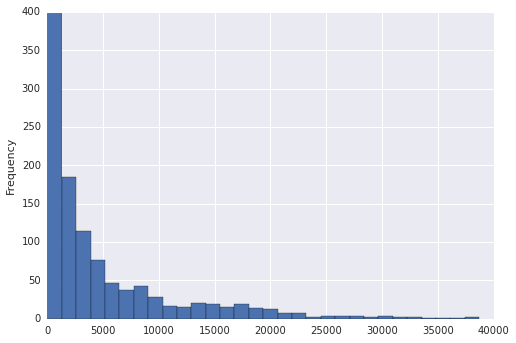

In [18]:
# store_df.groupby(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth']).count()
store_df[store_df.CompetitionDistance<40000].CompetitionDistance.plot.hist(bins=30)

In [29]:
weather_df.MeanDew_PointC.isnull().any()

False

In [31]:
X.Snow

Store  Date      
1      2013-01-01   -999
       2013-01-02   -999
       2013-01-03   -999
       2013-01-04   -999
       2013-01-05   -999
       2013-01-06   -999
       2013-01-07   -999
       2013-01-08   -999
       2013-01-09   -999
       2013-01-10   -999
       2013-01-11   -999
       2013-01-12   -999
       2013-01-13   -999
       2013-01-14   -999
       2013-01-15   -999
       2013-01-16   -999
       2013-01-17   -999
       2013-01-18   -999
       2013-01-19   -999
       2013-01-20   -999
       2013-01-21   -999
       2013-01-22   -999
       2013-01-23   -999
       2013-01-24   -999
       2013-01-25   -999
       2013-01-26   -999
       2013-01-27   -999
       2013-01-28   -999
       2013-01-29   -999
       2013-01-30   -999
                    ... 
1115   2015-07-02   -999
       2015-07-03   -999
       2015-07-04   -999
       2015-07-05   -999
       2015-07-06   -999
       2015-07-07   -999
       2015-07-08   -999
       2015-07-09   -999
       